In [1]:
%load_ext autoreload
%autoreload 2
import dotenv
dotenv.load_dotenv()

True

In [2]:
import glob
import os

experiment_ids = map(os.path.basename, glob.glob(os.path.join(os.environ['RESULTS_FOLDER'], "ballstate", "*")))
experiment_ids = sorted([i for i in experiment_ids if i > "20221020_113500.000000"])
from pprint import pprint
pprint(experiment_ids)

['20221020_113531.014548',
 '20221020_113539.061084',
 '20221020_113558.749623',
 '20221020_113912.494873',
 '20221020_113944.184728',
 '20221020_114023.204517',
 '20221020_114236.504866',
 '20221020_114333.792344',
 '20221020_114411.668765',
 '20221020_114609.541678',
 '20221020_114726.569384',
 '20221020_114800.987698',
 '20221028_115714.379451',
 '20221028_115755.721880',
 '20221028_115826.565959',
 '20221028_115829.151183',
 '20221028_131640.777522',
 '20221028_131705.563336',
 '20221028_131708.232791',
 '20221028_131844.277974',
 '20221028_181749.559233',
 '20221028_181849.501540',
 '20221028_182011.706280',
 '20221028_182144.059296',
 '20221028_182158.761076',
 '20221028_182739.718327',
 '20221028_182909.744425',
 '20221028_183256.065452',
 '20221028_183503.654138',
 '20221028_183610.454171',
 '20221028_184231.151187',
 '20221028_184312.236147',
 '20221028_184400.436408',
 '20221028_184954.254896',
 '20221028_185013.711733',
 '20221028_185502.909366',
 '20221028_185705.963862',
 

In [3]:
import os
from matplotlib import pyplot as plt
from experimentator import DataCollector
import numpy as np
from pyconfyg import Confyg

# Does adding a randomly initialized first layer alter the perfomances
subsets = ['testing', 'ballistic']
metrics = [
    ("FLYING Precision", "classification_metrics", lambda x: x['precision'].iloc[1]),
    ("FLYING Recall",    "classification_metrics", lambda x: x['recall'].iloc[1])
]

ids = {}
for experiment_id in experiment_ids:
    cfg = Confyg(os.path.join(os.environ['RESULTS_FOLDER'], "ballstate", experiment_id, "config.py")).dict
    if all([cfg[k] == v for k,v in [('with_diff', False), ('backbone', 'VGG'), ('pretrained', True)]]):
        ids[experiment_id] = cfg

for subset in subsets:
    fig, axes = plt.subplots(len(metrics), 1, figsize=(5,2), sharex=True)
    fig.suptitle(f"{subset} subset")
    for ax, (name, metric, fct) in zip(axes, metrics):
        for i, experiment_id in enumerate(ids):
            dc = DataCollector(os.path.join(os.environ['RESULTS_FOLDER'], "ballstate", experiment_id, "history.dcp"))
            label = "with randomly initialized first layer" if ids[experiment_id]['flayer'] else "without"
            ax.barh(width=fct(dc[f"{subset}_{metric}"]), y=-i, label=label)
            ax.set_yticks([])
            ax.set_ylabel(name, fontsize=7)
            ax.legend()
            ax.set_xlim([0,1])
    plt.show()

/home/gva/repositories/dataset_utilities/dataset_utilities/calib.py:5: UserWarning: Deprecated import. use `from deepsport_utilities.calib` instead of `from dataset_utilities.calib`
  warnings.warn("Deprecated import. use `from deepsport_utilities.calib` instead of `from dataset_utilities.calib`")


ball_states_dataset.pickle found in /scratch/gva/ball_states_dataset.pickle
ballistic_ball_views.pickle found in /scratch/gva/ballistic_ball_views.pickle


Traceback (most recent call last):
  File "/home/gva/repositories/pyconfyg/pyconfyg/core.py", line 66, in _exec
    exec(cmd, globals, locals)  # pylint: disable=exec-used
  File "<string>", line 39, in <module>
AttributeError: module 'experimentator.tf2_chunk_processors' has no attribute 'ChannelsReductionLayer'


InterpreterError: AttributeError at line 39: module 'experimentator.tf2_chunk_processors' has no attribute 'ChannelsReductionLayer'

import tensorflow as tf
import mlworkflow as mlwf
import experimentator
from experimentator.utils import find
from experimentator import Subset, SubsetType
import experimentator.tf2_experiment
import experimentator.wandb_experiment
import deepsport_utilities.ds.instants_dataset
from dataset_utilities.ds.raw_sequences_dataset import BallState
import tasks.ballstate
import tasks.classification
import models.other
import models.tensorflow
experiment_type = [experimentator.AsyncExperiment, experimentator.CallbackedExperiment, experimentator.tf2_experiment.TensorflowExperiment, tasks.ballstate.BallStateClassification]
batch_size = 16
with_diff = True
side_length = 114
output_shape = (side_length, side_length)
dataset_name = 'ball_states_dataset.pickle'
scale_min = 0.75
scale_max = 1.25
max_shift = 0
globals().update(locals())
transforms = (lambda scale: [tasks.ballstate.BallCropperTransform(output_shape=output_shape, scale_min=(scale_min * scale), scale_max=(scale_max * scale), margin=((side_length // 2) - max_shift)), deepsport_utilities.transforms.DataExtractorTransform(deepsport_utilities.ds.instants_dataset.views_transforms.AddImageFactory(), deepsport_utilities.ds.instants_dataset.views_transforms.AddNextImageFactory(), tasks.ballstate.AddBallStateFactory())])
dataset_splitter = experimentator.BasicDatasetSplitter()
dataset = mlwf.TransformedDataset(mlwf.PickledDataset(find(dataset_name)), transforms(1))
subsets = dataset_splitter(dataset)
dataset = mlwf.TransformedDataset(mlwf.PickledDataset(find('ballistic_ball_views.pickle')), transforms(0.5))
subsets.append(Subset('ballistic', SubsetType.EVAL, dataset))
globals().update(locals())
classes = [BallState(i) for i in range(4)]
callbacks = [experimentator.AverageMetrics(['.*loss']), experimentator.SaveWeights(), experimentator.SaveLearningRate(), experimentator.GatherCycleMetrics(), experimentator.LogStateDataCollector(), tasks.classification.ComputeClassifactionMetrics(), tasks.classification.ComputeConfusionMatrix(classes=classes), experimentator.wandb_experiment.LogStateWandB(), experimentator.LearningRateWarmUp()]
flayer = True
pretrained = True
backbone = 'VGG'
backbone_model = {'VGG': models.tensorflow.TensorflowBackbone('vgg16.VGG16', include_top=False, weights=('imagenet' if pretrained else None)), 'RN50': models.tensorflow.TensorflowBackbone('resnet50.ResNet50', include_top=False, weights=('imagenet' if pretrained else None))}[backbone]
globals().update(locals())
chunk_processors = [experimentator.tf2_chunk_processors.CastFloat(tensor_names=['batch_input_image', 'batch_input_image2']), (lambda chunk: chunk.update({'batch_input_diff': tf.subtract(chunk['batch_input_image'], chunk['batch_input_image2'])})), models.other.GammaAugmentation('batch_input_image'), (lambda chunk: chunk.update({'batch_input': (chunk['batch_input_image'] if (not with_diff) else tf.concat((chunk['batch_input_image'], chunk['batch_input_diff']), axis=3))})), experimentator.tf2_chunk_processors.Normalize(tensor_names=['batch_input']), (experimentator.tf2_chunk_processors.ChannelsReductionLayer() if flayer else None), models.tensorflow.TensorflowBackbone('vgg16.VGG16', include_top=False), models.other.LeNetHead(output_features=len(classes)), (lambda chunk: chunk.update({'batch_target': tf.one_hot(chunk['batch_ball_state'], len(classes))})), (lambda chunk: chunk.update({'loss': tf.keras.losses.binary_crossentropy(chunk['batch_target'], chunk['batch_logits'], from_logits=True)})), (lambda chunk: chunk.update({'loss': tf.reduce_mean(chunk['loss'])})), (lambda chunk: chunk.update({'batch_output': tf.nn.softmax(chunk['batch_logits'])}))]
learning_rate = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
eval_epochs = range(0, 101, 10)
jobid = 10279


In [ ]:
# Is pre-training on imagenet even necessary
subsets = ['testing', 'ballistic']
metrics = [
    ("FLYING Precision", "classification_metrics", lambda x: x['precision'].iloc[1]),
    ("FLYING Recall",    "classification_metrics", lambda x: x['recall'].iloc[1])
]

ids = {}
for experiment_id in experiment_ids:
    cfg = Confyg(os.path.join(os.environ['RESULTS_FOLDER'], "ballstate", experiment_id, "config.py")).dict
    if all([cfg[k] == v for k,v in [('with_diff', False), ('backbone', 'VGG'), ('flayer', False)]]):
        ids[experiment_id] = cfg

for subset in subsets:
    fig, axes = plt.subplots(len(metrics), 1, figsize=(5,2), sharex=True)
    fig.suptitle(f"{subset} subset")
    for ax, (name, metric, fct) in zip(axes, metrics):
        for i, experiment_id in enumerate(ids):
            dc = DataCollector(os.path.join(os.environ['RESULTS_FOLDER'], "ballstate", experiment_id, "history.dcp"))
            label = "pretrained on imagenet" if ids[experiment_id]['pretrained'] else "random initialization"
            ax.barh(width=fct(dc[f"{subset}_{metric}"]), y=-i, label=label)
            ax.set_yticks([])
            ax.set_ylabel(name, fontsize=7)
            ax.legend()
            ax.set_xlim([0,1])
    plt.show()

In [ ]:
# Does ResNet50 perform better than VGG16?

subsets = ['testing', 'ballistic']
metrics = [
    ("FLYING Precision", "classification_metrics", lambda x: x['precision'].iloc[1]),
    ("FLYING Recall",    "classification_metrics", lambda x: x['recall'].iloc[1])
]

ids = {}
for experiment_id in experiment_ids:
    cfg = Confyg(os.path.join(os.environ['RESULTS_FOLDER'], "ballstate", experiment_id, "config.py")).dict
    if all([cfg[k] == v for k,v in [('with_diff', False), ('pretrained', True), ('flayer', False)]]):
        ids[experiment_id] = cfg

for subset in subsets:
    fig, axes = plt.subplots(len(metrics), 1, figsize=(5,2), sharex=True)
    fig.suptitle(f"{subset} subset")
    for ax, (name, metric, fct) in zip(axes, metrics):
        for i, experiment_id in enumerate(ids):
            dc = DataCollector(os.path.join(os.environ['RESULTS_FOLDER'], "ballstate", experiment_id, "history.dcp"))
            label = ids[experiment_id]['backbone']
            ax.barh(width=fct(dc[f"{subset}_{metric}"]), y=-i, label=label)
            ax.set_yticks([])
            ax.set_ylabel(name, fontsize=7)
            ax.legend()
            ax.set_xlim([0,1])
    plt.show()

In [ ]:
# Does using difference between two consecutive images help?

subsets = ['testing', 'ballistic']
metrics = [
    ("FLYING Precision", "classification_metrics", lambda x: x['precision'].iloc[1]),
    ("FLYING Recall",    "classification_metrics", lambda x: x['recall'].iloc[1])
]

ids = {}
for experiment_id in experiment_ids:
    cfg = Confyg(os.path.join(os.environ['RESULTS_FOLDER'], "ballstate", experiment_id, "config.py")).dict
    if all([cfg[k] == v for k,v in [('backbone', 'RN50'), ('pretrained', True), ('flayer', True)]]):
        ids[experiment_id] = cfg

for subset in subsets:
    fig, axes = plt.subplots(len(metrics), 1, figsize=(5,2), sharex=True)
    fig.suptitle(f"{subset} subset")
    for ax, (name, metric, fct) in zip(axes, metrics):
        for i, experiment_id in enumerate(ids):
            dc = DataCollector(os.path.join(os.environ['RESULTS_FOLDER'], "ballstate", experiment_id, "history.dcp"))
            label = "with_diff" if ids[experiment_id]['with_diff'] else "single image"
            ax.barh(width=fct(dc[f"{subset}_{metric}"]), y=-i, label=label)
            ax.set_yticks([])
            ax.set_ylabel(name, fontsize=7)
            ax.legend()
            ax.set_xlim([0,1])
    plt.show()

In [ ]:
# Does using difference between two consecutive images help?

subsets = ['testing', 'ballistic']
metrics = [
    ("FLYING Precision", "classification_metrics", lambda x: x['precision'].iloc[1]),
    ("FLYING Recall",    "classification_metrics", lambda x: x['recall'].iloc[1])
]

ids = {}
for experiment_id in experiment_ids:
    cfg = Confyg(os.path.join(os.environ['RESULTS_FOLDER'], "ballstate", experiment_id, "config.py")).dict
    if all([cfg[k] == v for k,v in [('backbone', 'VGG'), ('pretrained', True), ('flayer', True)]]):
        ids[experiment_id] = cfg

for subset in subsets:
    fig, axes = plt.subplots(len(metrics), 1, figsize=(5,2), sharex=True)
    fig.suptitle(f"{subset} subset")
    for ax, (name, metric, fct) in zip(axes, metrics):
        for i, experiment_id in enumerate(ids):
            dc = DataCollector(os.path.join(os.environ['RESULTS_FOLDER'], "ballstate", experiment_id, "history.dcp"))
            label = "with_diff" if ids[experiment_id]['with_diff'] else "single image"
            ax.barh(width=fct(dc[f"{subset}_{metric}"]), y=-i, label=label)
            ax.set_yticks([])
            ax.set_ylabel(name, fontsize=7)
            ax.legend()
            ax.set_xlim([0,1])
    plt.show()

In [ ]:
# Does using difference between two consecutive images help?

subsets = ['testing', 'ballistic']
metrics = [
    ("FLYING Precision", "classification_metrics", lambda x: x['precision'].iloc[1]),
    ("FLYING Recall",    "classification_metrics", lambda x: x['recall'].iloc[1])
]

ids = {}
for experiment_id in experiment_ids:
    cfg = Confyg(os.path.join(os.environ['RESULTS_FOLDER'], "ballstate", experiment_id, "config.py")).dict
    if all([cfg[k] == v for k,v in [('backbone', 'VGG'), ('pretrained', True), ('flayer', False)]]):
        ids[experiment_id] = cfg
    if all([cfg[k] == v for k,v in [('backbone', 'VGG'), ('pretrained', True), ('flayer', True), ('with_diff', True)]]):
        ids[experiment_id] = cfg

        
for subset in subsets:
    fig, axes = plt.subplots(len(metrics), 1, figsize=(5,2), sharex=True)
    fig.suptitle(f"{subset} subset")
    for ax, (name, metric, fct) in zip(axes, metrics):
        for i, experiment_id in enumerate(ids):
            dc = DataCollector(os.path.join(os.environ['RESULTS_FOLDER'], "ballstate", experiment_id, "history.dcp"))
            label = "with_diff" if ids[experiment_id]['with_diff'] else "single image"
            ax.barh(width=fct(dc[f"{subset}_{metric}"]), y=-i, label=label)
            ax.set_yticks([])
            ax.set_ylabel(name, fontsize=7)
            ax.legend()
            ax.set_xlim([0,1])
    plt.show()

In [ ]:
# Does using difference between two consecutive images help?

subsets = ['testing', 'ballistic']
metrics = [
    ("FLYING Precision", "classification_metrics", lambda x: x['precision'].iloc[1]),
    ("FLYING Recall",    "classification_metrics", lambda x: x['recall'].iloc[1])
]

ids = {}
for experiment_id in experiment_ids:
    cfg = Confyg(os.path.join(os.environ['RESULTS_FOLDER'], "ballstate", experiment_id, "config.py")).dict
    if all([cfg[k] == v for k,v in [('backbone', 'RN50'), ('pretrained', True), ('flayer', False)]]):
        ids[experiment_id] = cfg
    if all([cfg[k] == v for k,v in [('backbone', 'RN50'), ('pretrained', True), ('flayer', True), ('with_diff', True)]]):
        ids[experiment_id] = cfg

        
for subset in subsets:
    fig, axes = plt.subplots(len(metrics), 1, figsize=(5,2), sharex=True)
    fig.suptitle(f"{subset} subset")
    for ax, (name, metric, fct) in zip(axes, metrics):
        for i, experiment_id in enumerate(ids):
            dc = DataCollector(os.path.join(os.environ['RESULTS_FOLDER'], "ballstate", experiment_id, "history.dcp"))
            label = "with_diff" if ids[experiment_id]['with_diff'] else "single image"
            ax.barh(width=fct(dc[f"{subset}_{metric}"]), y=-i, label=label)
            ax.set_yticks([])
            ax.set_ylabel(name, fontsize=7)
            ax.legend()
            ax.set_xlim([0,1])
    plt.show()

In [ ]:
import boto3
from experimentator.utils import find
from dataset_utilities.ds.raw_sequences_dataset import RawSequencesDataset, compute_size_range
from tqdm.auto import tqdm
from mlworkflow import PickledDataset
import os
from matplotlib import pyplot as plt
from deepsport_utilities.utils import color_cycle
import numpy as np


local_storage = "/DATA/datasets"
dummy = boto3.Session()
ds = RawSequencesDataset(local_storage=local_storage, progress_wrapper=tqdm, session=dummy)
ax = plt.figure().gca()
labels = []
for i, key in enumerate(tqdm(ds.yield_keys())):
    item = ds.query_item(key)
    r = compute_size_range(item.calibs)
    #print(key, r)
    ax.barh(left=r[0], y=i, width=r[1]-r[0], color=color_cycle[0])
    labels.append(key.arena_label)
    
from deepsport_utilities.ds.instants_dataset import InstantsDataset, DownloadFlags
from deepsport_utilities import import_dataset

dataset_folder = "/home/gva/repositories/deepsport/ballistic-raw-sequences"

dataset_config = {
    "dataset_folder": dataset_folder,
    "download_flags": DownloadFlags.WITH_ALL_IMAGES | DownloadFlags.WITH_CALIB_FILE,
}

ids = import_dataset(InstantsDataset, os.path.join(dataset_folder, "raw-basketball-sequences-dataset.json"), **dataset_config)
keys = list(ids.keys.all())
for j, label in enumerate(['STRASBOURG', 'GRAVELINES']):
    key = [k for k in keys if label in k.arena_label][0]
    labels.append(key.arena_label)
    item = ids.query_item(key)
    r = compute_size_range(item.calibs)
    color = np.array([255, 127, 14]) # color_cycle[1]
    ax.barh(left=r[0], y=i+j+1, width=r[1]-r[0], color=color/255)
    ax.barh(left=r[0]/2, y=i+j+1, width=(r[1]-r[0])/2, height=.2, color=color/255/2)
ax.set_xlim([0, 60])
ax.set_yticks(list(range(len(labels))))
ax.set_yticklabels(labels)

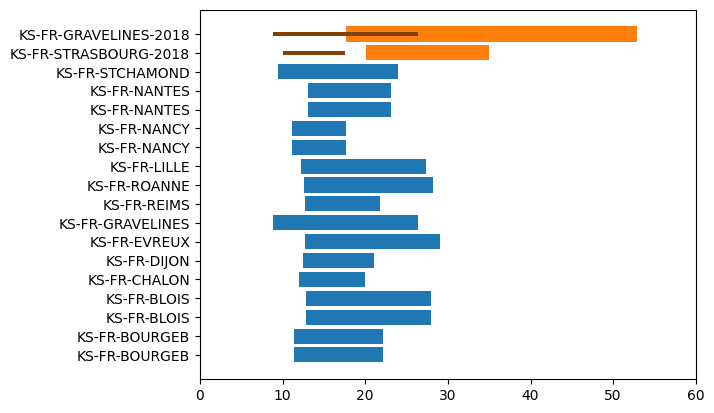

In [ ]:
from dataset_utilities.ds.raw_sequences_dataset import RawSequencesDataset, AddBallStatesTransform, BallState
from deepsport_utilities.utils import color_cycle
import boto3
from tqdm.auto import tqdm
from mlworkflow import TransformedDataset, FilteredDataset
from pprint import pprint
import json
from matplotlib import pyplot as plt

local_storage = "/DATA/datasets"
dummy = boto3.Session()
ds = RawSequencesDataset(local_storage=local_storage, progress_wrapper=tqdm, session=dummy)
ds = TransformedDataset(ds, [AddBallStatesTransform()])
ds = FilteredDataset(ds, lambda k,v: v.ball_states is not None)

states = [BallState(s) for s in range(1,4)]
ax = plt.figure().gca()
labels = []
for i, key in enumerate(ds.yield_keys()):
    labels.append((key.arena_label, key.game_id))
    item = ds.query_item(key)
    filename = "/DATA/datasets/raw-games/{}/{}/balls.json".format(key.arena_label, key.game_id)
    data = json.load(open(filename, "r"))
    offset = 0
    for j, s in enumerate(states):
        width = sum([item.ball_states[s][int(k)] if int(k) < len(item.ball_states[s]) else False for k in data.keys()])
        ax.barh(y=i, left=offset, width=width, label=str(s), color=color_cycle[j])
        offset += width
        
ax.legend([str(s) for s in states])
ax.set_yticks(list(range(len(labels))))
ax.set_yticklabels([f"{k[0]} {k[1]}" for k in labels])


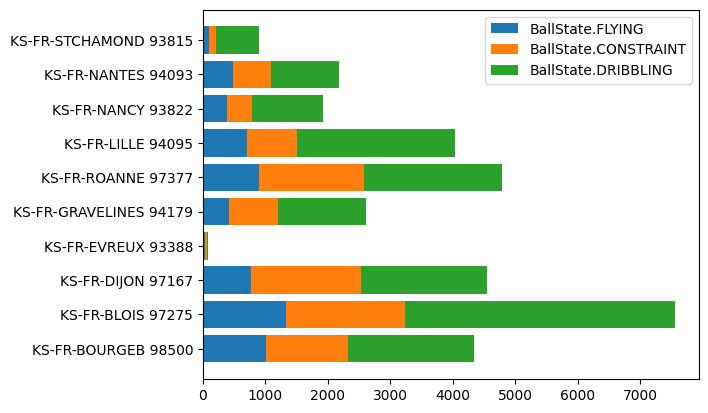